---
title: "Random Forest Classification for ML/Data Science Requirement"
format: html
jupyter: python3
execute:
  echo: true
  warning: false
  error: true
toc: true
code:fold: true
---


In [18]:
import pandas as pd

df = pd.read_csv("data/lightcast_job_postings.csv")
df.columns


/var/folders/ml/69jz_hln1nv6px47r10h6ccm0000gn/T/ipykernel_69958/923314599.py:3: DtypeWarning:

Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['ID', 'LAST_UPDATED_DATE', 'LAST_UPDATED_TIMESTAMP', 'DUPLICATES',
       'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'URL',
       ...
       'NAICS_2022_2', 'NAICS_2022_2_NAME', 'NAICS_2022_3',
       'NAICS_2022_3_NAME', 'NAICS_2022_4', 'NAICS_2022_4_NAME',
       'NAICS_2022_5', 'NAICS_2022_5_NAME', 'NAICS_2022_6',
       'NAICS_2022_6_NAME'],
      dtype='object', length=131)

In [19]:
ml_keywords = ["machine learning", "data science", "ai", "artificial intelligence", "deep learning", "data scientist"]

def requires_ml(skills):
    if pd.isnull(skills):
        return 0
    skills = skills.lower()
    return int(any(kw in skills for kw in ml_keywords))

df["REQUIRES_ML"] = df["SKILLS_NAME"].apply(requires_ml)

In [20]:
features = ["TITLE", "SOC_2021_4_NAME", "NAICS2_NAME", "MIN_EDULEVELS_NAME", "MIN_YEARS_EXPERIENCE"]
target = "REQUIRES_ML"

df = df[features + [target, 'BODY']].dropna()

In [21]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}

for col in features:
    if df_encoded[col].dtype == "object":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

In [22]:
from sklearn.model_selection import train_test_split

X = df_encoded[features]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5257
           1       0.72      0.72      0.72      4614

    accuracy                           0.74      9871
   macro avg       0.74      0.74      0.74      9871
weighted avg       0.74      0.74      0.74      9871



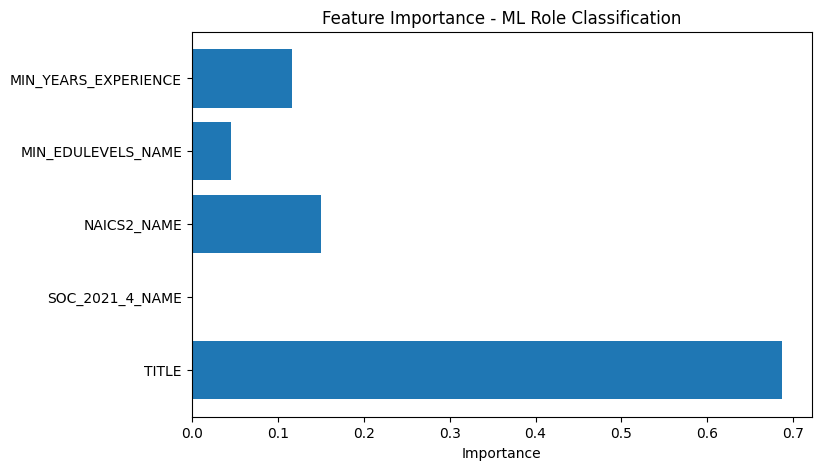

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(features, rf.feature_importances_)
plt.xlabel("Importance")
plt.title("Feature Importance - ML Role Classification")
plt.show()

This bar chart displays the feature importance scores from a random forest model predicting whether a job role involves ML/Data Science. The most influential feature by far in the model is the job title (TITLE), which has a significantly higher importance than all other variables. Secondary contributors include industry classification (NAICS2_NAME) and minimum years of experience, where education level and SOC code had relatively low influence on the model’s prediction. This is suggesting that the job title alone carries strong predictive power for identifying ML-related roles.

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Cleaned job descriptions
df['BODY_clean'] = df['BODY'].fillna("").str.lower()

# Target
y = df['REQUIRES_ML']  # this should be a binary 1/0 column

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['BODY_clean'])

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      6644
           1       0.92      0.90      0.91      5694

    accuracy                           0.92     12338
   macro avg       0.92      0.92      0.92     12338
weighted avg       0.92      0.92      0.92     12338



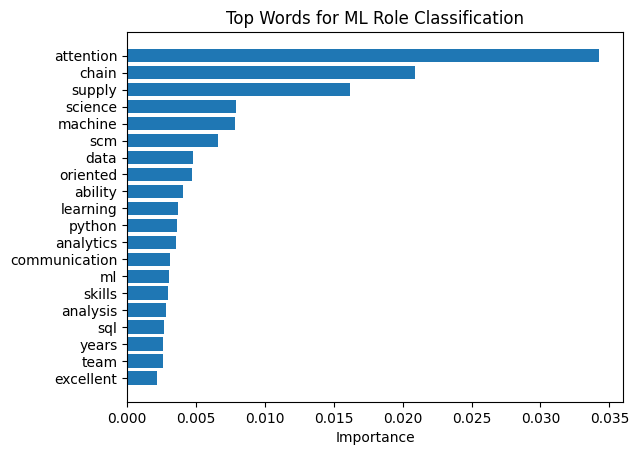

In [27]:
import numpy as np

importances = model.feature_importances_
top_idx = np.argsort(importances)[-20:]
top_words = [tfidf.get_feature_names_out()[i] for i in top_idx]

plt.barh(top_words, importances[top_idx])
plt.title("Top Words for ML Role Classification")
plt.xlabel("Importance")
plt.show()

This bar chart shows the top words contributing to the classification of job roles as Machine Learning (ML)related based on job description data. Surprisingly, the most influential words are "attention," "chain," and "supply", which could be an indication of overlap with supply chain roles or reflect noise in the model. More expected terms like "machine," "learning," "python," "AI," and "analytics" also appear, reinforcing that relevant technical language still plays a role in identifying ML-related positions. The presence of general words like "strong" or "communication" suggests that not all influential terms are strictly technical.

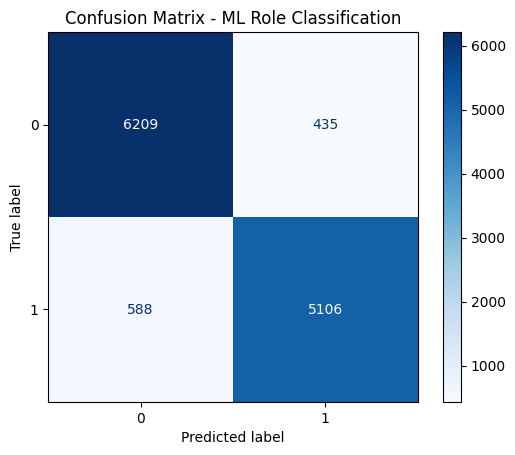

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - ML Role Classification")
plt.show()

We selected a combination of structured and unstructured features to predict whether a job role requires Machine Learning or Data Science. Structured features such as TITLE, SOC_2021_4_NAME, NAICS2_NAME, MIN_EDULEVELS_NAME, and MIN_YEARS_EXPERIENCE were chosen based on domain relevance—these fields reflect the role's function, industry, required education, and experience level, all of which can signal ML-related requirements. Additionally, we included the job description BODY text, applying TF-IDF vectorization to extract key terms. This allowed the model to learn from nuanced language patterns within postings. Feature importance and performance metrics confirm that both structured metadata and text data contribute meaningfully to classification accuracy.